# 4. 从零开始实现一个用于文本生成的GPT模型

本章涵盖以下内容：

+ **编写一个类 GPT 的大语言模型（LLM），可以训练其生成类人文本（指的是由人工智能模型生成的文本，这些文本在语言表达、语法结构、情感表达等方面与人类自然书写的文本非常相似）**
+ **对网络层的激活值进行归一化，以稳定神经网络的训练过程**
+ **在深度神经网络中添加快捷连接，以更高效地训练模型**
+ **通过实现 Transformer 模块来构建不同规模的 GPT 模型**
+ **计算 GPT 模型的参数数量和存储需求**

-----

- [4.1 实现 LLM 的架构](#41-实现-llm-的架构)
- [4.2 使用层归一化对激活值进行标准化](#42-使用层归一化对激活值进行标准化)
- [4.3 实现带有 GELU 激活函数的前馈神经网络](#43-实现带有-gelu-激活函数的前馈神经网络)
- [4.4 添加快捷连接](#44-添加快捷连接)
- [4.5 在 Transformer 模块中连接注意力层与线性层](#45-在-transformer-模块中连接注意力层与线性层)
- [4.6 实现 GPT 模型](#46-实现-gpt-模型)
- [4.7 生成文本](#47-生成文本)
- [4.8 本章摘要](#48-本章摘要)

-----


在上一章中，我们学习并实现了多头注意力机制，这是大语言模型（LLM）的核心组件之一。本章将进一步实现 LLM 的其他组件，并将它们组装成一个与 GPT 类似结构的模型。我们将在下一章中训练该模型，以生成类人文本，具体过程如图 4.1 所示。

<img src="../image/chapter4/figure4.1.png" width="75%" />

大语言模型（LLM）架构（见图 4.1）由多个模块构成，我们将在本章中实现这些模块。接下来的内容，我们首先从整体视角介绍模型架构，然后详细讲解各个组件。



## 4.1 实现 LLM 的架构

LLM（如GPT，即生成式预训练 Transformer，Generative Pretrained Transformer）是一种大型深度神经网络架构，设计用于逐词（或逐 token）生成新文本。然而，尽管模型规模庞大，其结构却并没有想象中那么复杂，因为模型的许多组件是重复的（后文将对此展开说明）。图 4.2 展示了一个类 GPT 的 LLM 的整体视图，并突出了其主要组成部分。

<img src="../image/chapter4/figure4.2.png" width="75%" />

如图 4.2 所示，我们已经在之前的章节中讲解过几个模块，如输入的分词和嵌入，以及掩码多头注意力模块。本章的重点是实现 GPT 模型的核心结构（包括 Transformer 模块）。我们将在下一章对该模型进行训练，使其能够生成类人文本。

在前几章中，为了简单起见，我们使用了较小的嵌入维度，确保概念和示例能够更方便地展示在一页内。而在本章中，我们将逐步扩展模型规模，达到小型 GPT-2 模型的大小（拥有1.24 亿参数量的最小版本）。该模型在 Radford 等人的论文《Language Models are Unsupervised Multitask Learners.》中有详细介绍。请注意，尽管最初的报告中提到参数量为 1.17 亿，但后来更正为 1.24 亿。

第 6 章将重点介绍如何将预训练权重加载到我们的实现中，并将其调整为更大的 GPT-2 模型版本（包括 3.45 亿、7.62 亿和 15.42 亿参数量规模）。在深度学习和 GPT 等大语言模型的背景下，‘参数’一词指的是模型的可训练权重。这些权重本质上是模型的内部变量，在训练过程中不断调整和优化，以最小化特定的损失函数。这种优化使得模型能够从训练数据中学习。

例如，在一个神经网络层中，其权重由一个 2,048 x 2,048 维的矩阵（或张量）表示，这个矩阵的每个元素都是一个参数。由于该矩阵有 2,048 行和 2,048 列，因此该层的总参数数量为 2,048 乘以 2,048，即 4,194,304 个参数。

> [!NOTE]
>
> **GPT-2 与 GPT-3 的比较**
>
> 我们之所以关注 GPT-2，是因为 OpenAI 已公开了其预训练模型的权重，这些权重将在第 6 章中加载到我们的实现中。GPT-3 的模型架构基本上与 GPT-2 相同，只是将参数规模从 GPT-2 的 15 亿增加到了 1750 亿，同时在更多的数据上进行了训练。截至本文撰写时，GPT-3 的权重尚未公开。对于学习如何实现LLM，GPT-2 是更好的选择，因为它可以在单台笔记本电脑上运行，而 GPT-3 的训练和推理则需要 GPU 集群。根据 Lambda Labs 的估算，在单块 V100 数据中心 GPU 上训练 GPT-3 需要 355 年，而在消费级的 RTX 8000 GPU 上则需要 665 年。

我们通过以下 Python 字典来定义小型 GPT-2 模型的配置，稍后将在代码示例中使用该配置：

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

在 GPT_CONFIG_124M 字典中，我们使用简明的变量名，以保证清晰且避免代码行过长：

+ `vocab_size`指的是第 2 章中 BPE 分词器使用的 50,257 个词汇的词表大小。
+ `context_length`表示模型所能处理的最大输入 token 数（在第 2 章介绍位置嵌入时讨论过）。
+ `emb_dim`表示嵌入维度，将每个 token 转换为 768 维的向量。
+ `n_layers`指定模型中 Transformer 模块的层数，后续章节将对此详解。
+ `drop_rate`表示 dropout 机制的强度（例如，0.1 表示丢弃 10% 的隐藏单元），用于防止过拟合，具体内容请回顾第 3 章。
+ `qkv_bias` 参数决定是否在多头注意力的查询、键和值的线性层中加入偏置向量。我们最初会禁用该选项，以遵循现代大语言模型的标准，之后在第 6 章加载 OpenAI 预训练的 GPT-2 权重时再重新考虑该设置。

使用上述配置，我们将从本章开始实现一个GPT占位架构（DummyGPTModel），如图4.3所示。这将为我们提供一个全局视图，了解所有组件如何组合在一起，以及在接下来的章节中需要编写哪些其他组件来组装完整的GPT模型架构。

<img src="../image/chapter4/figure4.3.png" width="75%" />

图 4.3 中显示的编号框说明了我们编写最终 GPT 架构所需理解的各个概念的顺序。我们将从第 1 步开始，这是一个我们称之为 DummyGPTModel 的 GPT 占位架构：

In [2]:
# Listing 4.1 A placeholder GPT model architecture class
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])      #A
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])                       #B
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):                                       #C
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):                                                     #D
        return x

class DummyLayerNorm(nn.Module):                                              #E
    def __init__(self, normalized_shape, eps=1e-5):                           #F
        super().__init__()

    def forward(self, x):
        return x


#A 为 TransformerBlock 设置占位符
#B 为 LayerNorm 设置占位符
#C 一个简单的占位类，后续将被真正的 TransformerBlock 替换
#D 该模块无实际操作，仅原样返回输入
#E 一个简单的占位类，后续将被真正的 DummyLayerNorm 替换
#F 此处的参数仅用于模拟LayerNorm接口

此代码中的 DummyGPTModel 类使用 PyTorch 内置的神经网络模块（nn.Module）定义了一个简化版的类 GPT 模型。该类包括 token 嵌入、位置嵌入、dropout、多个 Transformer 模块（DummyTransformerBlock）、最终的层归一化（DummyLayerNorm）以及线性输出层（out_head）。模型配置通过 Python 字典传入，稍后将传入我们之前创建的 GPT_CONFIG_124M 字典。

`forward`方法定义了数据在模型中的流动方式：计算输入索引的 token 嵌入和位置嵌入，应用 dropout，通过 transformer block 处理数据，应用归一化，最后通过线性输出层生成 logits。

上面的代码已经可以正常运行，不过需要先准备输入数据，在本节后面我们会看到运行效果。需要注意的是，目前代码中我们使用了 `DummyLayerNorm` 和 `DummyTransformerBlock` 作为 Transformer 模块和层归一化的占位符，实际的实现会在后续部分详细介绍。

接下来，我们将准备输入数据并初始化一个新的 GPT 模型，以展示它的用法。基于第二章实现的分词器，图 4.4 展示了数据在 GPT 模型中流入和流出的整体流程。

<img src="../image/chapter4/figure4.4.png" width="75%" />

根据图 4.4 的步骤，我们使用第 2 章介绍的 tiktoken 分词器对包含两个文本的批量输入进行分词，以供 GPT 模型使用：

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


接下来，我们初始化一个拥有 1.24 亿参数的 DummyGPTModel 模型实例，并将分词后的数据批量输入到模型中：

In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


输出的张量有两行，每行对应一段文本。每段文本包含 4 个 token，每个 token 是一个 50,257 维的向量，维度大小与分词器的词汇表相同。

嵌入层的维度为 50,257，因为每个维度对应词汇表中的一个唯一 token。在之后的处理中，我们会将这些 50,257 维向量转换回 token ID，然后再解码成单词。

在对 GPT 架构及其输入输出进行了大概介绍之后，接下来的章节中将编写各个占位模块的实现，首先从用真实的层归一化类替换之前代码中的 DummyLayerNorm 开始。

---

## 4.2 使用层归一化对激活值进行标准化

在训练深度神经网络时，梯度消失或梯度爆炸问题有时会带来挑战。这些问题会导致训练过程不稳定，使得网络难以有效调整权重，也就是说，模型难以找到一组能最小化损失函数的参数。换句话说，模型很难从数据中学习到足够准确的模式，以支持其做出准确的预测或决策。（如果您对神经网络训练或梯度概念不熟悉，可参考附录 A 的 A.4 节《自动微分入门》。但要理解本书内容，不需要对梯度概念有深刻的理解。）

> [!TIP]
>
> **个人思考：** 虽然对文本内容的理解并不需要深度掌握梯度的概念，但如果我们在学习过程中能习惯去发散，往往能帮助我们对所学知识理解的更深刻，下面我们就来聊一下梯度。
>
> 梯度本质上是一个**变化率**，描述了某个值（例如函数输出值）对另一个值（如输入变量）的变化趋势。简单来说，梯度告诉我们在当前位置上，朝哪个方向移动能让某个目标值增加或减少得更快。
>
> 举例：山坡上的爬山者
>
> 假设你站在一座山的某个位置，想要找到最快下山的路线。你会怎么做呢？首先你会注意到山坡的倾斜度（也就是梯度），倾斜越陡的地方，就意味着朝这个方向走可以让你更快地下降海拔。
>
> 在这个例子中：
>
> + **你的当前位置**代表模型当前的参数值。
> + **山坡的倾斜度**就是梯度，表示你在当前位置向下走的快慢和方向。
> + **往斜坡最陡的方向走**相当于使用梯度更新模型参数，使得海拔（也就是损失值）尽快下降。
>
> 而大模型在应用梯度的概念时，首先会设计一个损失函数，用来衡量模型的预测结果与目标结果的差距。在训练过程中，它通过梯度去帮助每个模型参数不断调整来快速减少损失函数的值，从而提高模型的预测精度。

本节中，我们将实现层归一化，以提高神经网络训练的稳定性和效率。

归一化的核心思想是将神经网络层的激活（输出）调整为均值为 0，方差为 1（即单位方差）。这种调整可以加速权重的收敛速度，确保训练过程的一致性和稳定性。正如上一节提到的，在 GPT-2 和现代 Transformer 架构中，层归一化通常应用于多头注意力模块的前后以及最终输出层之前。

在我们用代码实现层归一化之前，先通过图 4.5 了解一下层归一化的工作原理。

<img src="../image/chapter4/figure4.5.png" width="75%" />

我们可以通过以下代码重现图 4.5 中的示例，其中实现了一个具有 5 个输入和 6 个输出的神经网络层，并将其应用于两个输入样本：

In [5]:
torch.manual_seed(123)
# 创建2个训练样本，每个样本有5个维度（特征）
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


打印出的张量中，第一行表示第一个输入样本的层输出，第二行表示第二个输入样本的层输出。

我们实现的神经网络层包含一个线性层，后接一个非线性激活函数 ReLU，这是神经网络中的标准激活函数。如果你不熟悉 ReLU，只需了解它的作用是将负值设为 0，确保输出层中没有负值。在 GPT 中，我们将使用另一种更复杂的激活函数，后续章节会介绍。

在对这些输出应用层归一化之前，我们先查看其均值和方差：

In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


以上均值张量的第一行包含第一个输入样本的均值，第二行输出包含第二个输入样本的均值。

在计算均值或方差等操作时使用 `keepdim=True` 参数，可以确保输出张量的维度与输入张量相同，即使该操作通过`dim`参数减少了张量的维度。例如，如果不使用 `keepdim=True`，返回的均值张量将是一个二维向量 `[0.1324, 0.2170]`，而使用 `keepdim=True` 后，返回的张量则会是一个 `2×1` 的矩阵 `[[0.1324], [0.2170]]`。

`dim` 参数用于指定张量中进行统计计算（如均值或方差）的维度，具体如图 4.6 所示。

<img src="../image/chapter4/figure4.6.png" width="75%" />

如图 4.6 所示，对于二维张量（如矩阵），在进行均值或方差计算等操作时，使用 `dim=-1` 等同于使用 `dim=1`，因为 `-1` 指的是张量的最后一个维度，即二维张量中的列。在后续对 GPT 模型加入层归一化时，模型会生成形状为 `[batch_size, num_tokens, embedding_size]` 的三维张量，我们依然可以使用 `dim=-1` 对最后一个维度进行归一化，而无需将 `dim=1` 改为 `dim=2`。

接下来，我们将对之前获得的层输出应用层归一化。该操作包括减去均值，并除以方差的平方根（即标准差）：

In [9]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[-5.9605e-08],
        [ 1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


可以看到，归一化后的层输出现在也包含了负值，其均值为零，方差为 1。

请注意，输出张量中的值`2.9802e-08`是`2.9802 × 10^-8`的科学记数法表示，用十进制形式表示为`0.0000000298`。这个值虽然非常接近 0，但由于计算机表示数字的精度有限，会产生微小的数值误差，因此不完全等于 0。

为提高可读性，我们可以将 sci_mode 设置为 False，从而关闭张量值的科学计数法显示模式：

In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


在本节内容中，我们已逐步实现并应用了层归一化。现在将这个过程封装到一个 PyTorch 模块中，以便后续在 GPT 模型中使用。

In [13]:
# Listing 4.2 A layer normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

以上是对层归一化的具体实现，它作用于输入张量 `x` 的最后一个维度，该维度表示嵌入维度（emb_dim）。变量 `eps` 是一个小常数（epsilon），在归一化过程中加到方差上，以防止出现除零错误。`scale` 和 `shift` 是两个可训练参数（与输入具有相同的维度）。大语言模型（LLM）在训练中会自动调整这些参数，以改善模型在训练任务上的性能。这使得模型能够学习适合数据处理的最佳缩放和偏移方式。

> [!NOTE]
>
> **有偏方差**
>
> 我们在方差计算方法中选择了设置 `unbiased=False`。对于好奇其含义的读者，可以理解为我们在方差公式中直接用样本数 n 作为分母，不使用贝塞尔校正（通常分母使用 n−1 以校正样本方差估计中的偏差）。这种决定会导致所谓的有偏方差估计。对于大语言模型（LLM）来说，其嵌入维度 n 通常非常大，因此使用 n 和 n−1 的差异实际上可以忽略不计。我们选择这种方式是为了确保与 GPT-2 模型的归一化层兼容，并保持与 TensorFlow 的默认行为一致，后者用于实现最初的 GPT-2 模型。这种设置确保我们的方法与第 6 章中将加载的预训练权重兼容。

现在让我们在实践中尝试LayerNorm模块并将其应用于批量输入：

In [14]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


结果表明，层归一化代码运行正常，将两个输入的均值归一化为 0，方差归一化为 1。

在本节中，我们介绍了实现 GPT 架构所需的一个基础模块（`LayerNorm`），如图 4.7 所示。

<img src="../image/chapter4/figure4.7.png" width="75%" />

在下一节中，我们将探讨大语言模型中使用的 GELU 激活函数，它将替代我们在本节使用的传统 ReLU 函数。

> [!NOTE]
>
> **层归一化与批量归一化的区别**
>
> 如果你熟悉批量归一化这种常见的传统神经网络归一化方法，可能会好奇它与层归一化的区别。与在数量维度上进行归一化的批量归一化不同，层归一化是在特征维度上进行归一化。LLM 通常需要大量计算资源，而可用的硬件资源或特定的使用场景可能会限制训练或推理过程中的批量大小。由于层归一化对每个输入的处理不依赖批量大小，因此在这些场景下提供了更高的灵活性和稳定性。这对于分布式训练或资源受限的环境中部署模型尤其有利。

---

## 4.3 实现带有 GELU 激活函数的前馈神经网络

在本节中，我们将实现一个小型神经网络子模块，作为 LLM 架构中的 Transformer 模块的一部分。我们首先实现 GELU 激活函数，它将在这个神经网络子模块中起着至关重要的作用。（关于在 PyTorch 中实现神经网络的更多信息，请参考附录 A 的 A.5 节：实现多层神经网络）

过去，ReLU 激活函数因其简单且有效，常用于各种神经网络架构中。但在大语言模型中，除了传统的 ReLU，还使用了其他几种激活函数，其中两个典型的例子是 GELU（高斯误差线性单元）和 SwiGLU（Swish 门控线性单元）。

GELU 和 SwiGLU 是更复杂、平滑的激活函数，分别结合了高斯分布和 sigmoid 门控线性单元。与较简单的 ReLU 不同，这些激活函数能为深度学习模型提供更好的性能。

GELU 激活函数可以通过多种方式实现，其确切版本定义为 $GELU(x) = x ⋅ Φ(x)$，其中 $Φ(x)$ 是标准正态分布的累积分布函数。然而在实践中，通常会采用计算开销更低的近似实现（最初的 GPT-2 模型也是用这种近似实现进行训练的）：

$$ \text{GELU}(x) \approx 0.5 \cdot x \cdot\left(1+\tanh \left[\sqrt{(2 / \pi)} \cdot\left(x+0.044715 \cdot x^{3}\right]\right)\right. $$

我们可以编码将该函数实现为一个 PyTorch 模块，如下所示：

In [15]:
# Listing 4.3 An implementation of the GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

接下来，为了更直观的观察 GELU 函数的形状，并与 ReLU 函数进行对比，我们将这两个函数并排绘制：

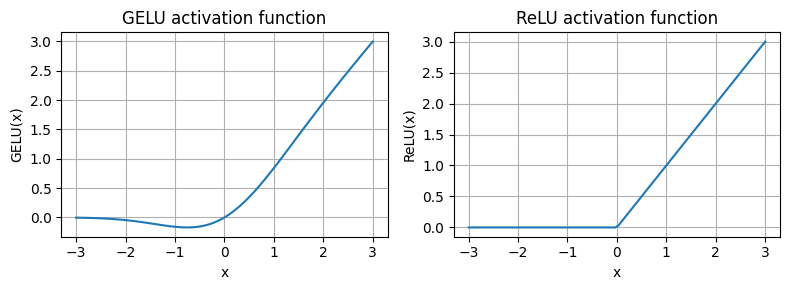

In [16]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

# 在 -3 到 3 的范围内生成 100 个样本数据点
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

如图 4.8 所示，ReLU 是一个分段线性函数，输入为正时输出输入值本身，否则输出零。而 GELU 是一种平滑的非线性函数，它近似于 ReLU，但在负值上也具有非零梯度。

<img src="../image/chapter4/figure4.8.png" width="75%" />

如图 4.8 所示，GELU 的平滑性使其在训练过程中具有更好的优化特性，能够对模型参数进行更细微的调整。相比之下，ReLU 在零点处有一个拐角，这在网络深度较大或结构复杂时可能会增加优化难度。此外，ReLU 对所有负输入的输出为零，而 GELU 对负值允许一个小的非零输出。这意味着在训练过程中，接收负输入的神经元也能对学习过程产生一定的贡献，尽管贡献程度不及正输入。

接下来让我们使用 GELU 激活函数实现一个小型的神经网络模块 FeedForward，该模块稍后会应用在 LLM 的 Transformer 模块中：

In [21]:
# Listing 4.4 A feed forward neural network module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

如代码所示，FeedForward 模块是一个小型神经网络，由两个线性层和一个 GELU 激活函数组成。在 1.24 亿参数的 GPT 模型中，该模块可以接收批量输入，每个输入 token 是一个 768 维的向量表示。这一嵌入维度大小通过 `GPT_CONFIG_124M` 配置字典中的 `GPT_CONFIG_124M["emb_dim"]` 参数指定。

图 4.9 展示了当我们输入数据后，这个前馈网络内部如何调整嵌入维度。

<img src="../image/chapter4/figure4.9.png" width="75%" />

按照图 4.9 中的示例，我们初始化一个新的 FeedForward 模块，设置 token 嵌入维度为 768，并输入一个包含 2 个样本且每个样本有 3 个 token 的数据集：

In [22]:
ffn = FeedForward(GPT_CONFIG_124M)
# 创建一个 batch 大小为 2 的示例输入
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


显然，输出张量的形状与输入张量相同。

我们在本节实现的 FeedForward 模块对模型能力的增强（主要体现在从数据中学习模式并泛化方面）起到了关键作用。尽管该模块的输入和输出维度相同，但在内部，它首先通过第一个线性层将嵌入维度扩展到一个更高维度的空间（如图 4.10 所示）。之后再接入非线性 GELU 激活，最后再通过第二个线性层变换回原始维度。这样的设计能够探索更丰富的表示空间。

> [!TIP]
>
> **个人思考：** 这段描述一笔带过了扩展和收缩嵌入维度为模型训练带来的好处，那到底该如何理解这样的设计能够探索更丰富的表示空间呢？
>
> 可以将扩展和收缩的过程类比为一种**数据解压缩与重新压缩**的机制：
>
> + **扩展（解压缩）**：假设我们有一段压缩的音乐文件（例如 MP3），里面包含了音频的基本信息。通过解压缩（扩展），我们把这个文件变成了一个更高质量的音频格式，允许我们看到（听到）更多的细节，比如乐器的细微声响和音调变化。
> + **特征提取**：接着，我们可以在这个高质量的音频文件中应用各种音频处理算法（相当于非线性激活），分析出更多细节，比如每种乐器的声音特点。
> + **收缩（压缩）**：最后，我们将音频再次压缩为一种更适合传输和存储的格式。虽然最终文件变小了，但这个文件已经包含了之前提取出的更多的声音细节。
>
> 将这种理解再应用到神经网络中，扩展后的高维空间可以让模型“看到”输入数据中更多的隐藏特征，提取出更丰富的信息。然后在收缩回低维度时，这些丰富的特征被整合到了输入的原始维度表示中，使模型最终的输出包含更多的上下文和信息。

<img src="../image/chapter4/figure4.10.png" width="75%" />

此外，输入输出维度保持一致也有助于简化架构，方便堆叠多层（在后续的章节实现），无需调整各层维度，从而提升了模型的可扩展性。

如图4.11所示，我们目前已经实现了LLM 架构中的大部分模块。

<img src="../image/chapter4/figure4.11.png" width="75%" />

下一节，我们将介绍“快捷连接”的概念，即在神经网络的不同层之间插入的连接结构，它对于提升深度神经网络架构的训练性能非常重要。

---

## 4.4 添加快捷连接

接下来，我们来讨论快捷连接（也称跳跃连接或残差连接）的概念。快捷连接最初是在计算机视觉中的深度网络（尤其是残差网络）提出的，用于缓解梯度消失问题。梯度消失是指在训练中指导权重更新的梯度在反向传播过程中逐渐减小，导致早期层（靠近输入端的网络层）难以有效训练，如图 4.12 所示。

<img src="../image/chapter4/figure4.12.png" width="75%" />

如图 4.12 所示，快捷连接通过跳过一层或多层，为梯度提供一条更短的流动路径，这是通过将某层的输出加到后续层的输出上来实现的。因此，这种连接方式也称为跳跃连接。在反向传播中，快捷连接对保持梯度流动至关重要。

在以下代码示例中，我们将实现图 4.12 中所示的神经网络，以展示如何在前向传播方法中添加快捷连接：

In [23]:
# Listing 4.5 A neural network to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            # Implement 5 layers
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

以上代码实现了一个 5 层的深度神经网络，每层包括一个线性层和 GELU 激活函数。在前向传播中，我们将输入逐层传递，同时如果 `self.use_shortcut` 属性设置为 True，则会添加图 4.12 所示的快捷连接。

我们将使用以下代码初始化一个没有快捷连接的神经网络，其中每一层都被初始化为接受 3 个输入值并返回 3 个输出值。最后一层则返回一个单一的输出值：

In [24]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

接下来，我们实现一个用于在模型反向传播过程中计算梯度的函数：

In [25]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

上述代码中，我们定义了一个损失函数，用来计算模型输出与用户指定目标（此处为简单起见，目标值设为 0）之间的差距。接着，当调用 `loss.backward()` 时，PyTorch 会为模型的每一层计算损失的梯度。我们可以通过 `model.named_parameters()` 遍历权重参数。假设某层的权重参数是一个 3×3 的矩阵，那么这一层会有 3×3 的梯度值。然后我们打印出这 3×3 梯度值的绝对均值，以便得到每层的单一梯度值，从而更容易比较各层之间的梯度大小。

简而言之，`.backward()` 是 PyTorch 中一个用于自动计算损失梯度的便捷方法，这在模型训练过程中很重要。它让我们无需亲自实现梯度计算的数学过程，从而大大简化了深度神经网络的开发过程。如果您对梯度和神经网络训练不熟悉，建议参考附录 A 中的 A.4 节：**轻松实现自动微分** 和 A.7 节：**典型的训练循环**。

现在让我们使用 `print_gradients` 函数，并将其应用到没有跳跃连接的模型上：

In [26]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031


从 `print_gradients` 函数的输出可以看出，梯度在从最后一层（layers.4）到第一层（layers.0）时逐渐减小，这种现象称为梯度消失问题。

我们再来创建一个带有跳跃连接的模型，看看它的表现如何：

In [27]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


从输出结果可以看到，最后一层（layers.4）的梯度依然比其他层更大。然而，随着接近第一层（layers.0），梯度值逐渐趋于稳定，并未缩小到几乎消失的程度。

总之，快捷连接在解决深度神经网络中的梯度消失问题方面具有重要作用。作为 LLM 的核心构建单元，快捷连接可以确保各层之间的梯度稳定流动，从而帮助 GPT 模型更有效的训练（下一章实现训练过程）。

在介绍了快捷连接后，我们将在下一节把之前讲解的所有概念（层归一化、GELU 激活、前馈网络模块和快捷连接）整合进一个 Transformer 模块中，这是构建 GPT 架构所需的最后一个模块。

> [!TIP]
>
> **个人思考：** 看到这里，不知各位读者是否真正理解了快捷连接在深度神经网络中的作用，这里其实涉及到快捷连接的两个重要的作用：
>
> + **保持信息（或者说是特征）流畅传递**
> + **缓解梯度消失问题**
>
> 让我们逐一解读，LLM 中的每个Transformer 模块通常包含两个重要组件（**可以先阅读完4.5节，再回头看这里的解读**）：
>
> 1. **自注意力层（Self-Attention Layer）**：计算每个 token 与其他 token 的关联，帮助模型理解上下文。
> 2. **前馈网络（Feed Forward Network）**：对每个 token 的嵌入（embedding）进行进一步的非线性转换，使模型能够提取更复杂的特征。
>
> 这两个部分都在层归一化（Layer Normalization）和快捷连接（Shortcut Connections）的配合下工作。
>
> 假设我们正在训练一个 LLM ，并希望它理解下面的句子：
>
> `The cat sat on the mat because it was tired.`
>
> 模型需要通过多个 Transformer 层来逐层处理该句子，使得每个词（token）在上下文中能被理解。为了达到这一目的，每个 token 的嵌入会在多层中进行注意力计算和前馈网络处理。
>
> 1. **没有快捷连接时的情况**
>
>    如果没有快捷连接，那么每个 Transformer 层的输出就直接传递到下一个层。这种情况下，网络中的信息流大致如下：
>
>    + **层间信息传递的局限**：假设当前层的注意力机制计算出了“it”和“cat”之间的关系，如果前馈网络进一步转换了这个信息，那么下一层就只能基于该层的输出，可能丢失一些最初的语义信息。
>    + **梯度消失**：在训练过程中，梯度从输出层逐层向回传播。如果层数过多，梯度会逐渐变小（即“梯度消失”），从而导致模型难以有效更新前面层的参数。
>
>    这种情况下，由于信息不能直接流动到更深层次的网络，可能会导致模型难以有效捕捉到前层的一些原始信息。
>
> 2. **加入快捷连接后的情况**
>
>    加入快捷连接后，信息可以在层与层之间**直接跳跃**。例如，假设在第 $n$ 层，我们有输入 $X_n$，经过注意力和前馈网络得到输出 $F(X_n)$。加入快捷连接后，这一层的输出可以表示为：
>
>    $$\text { 输出 }=X_{n}+F\left(X_{n}\right)$$
>
>    这意味着第 n 层的输出不仅包含了这一层的新信息 $F(X_n)$，还保留了原始输入 $X_n$ 的信息。下面是这样做的好处：
>
>    - **保留原始信息**
>
>      快捷连接让输入的原始信息直接传递到后续层，避免了在多层处理过程中丢失重要信息。例如，“it” 和 “cat” 之间的关系在较浅层中被捕捉到后，即使后面的层有进一步的处理，模型依然能够从快捷连接中获得最初的上下文信息。
>
>    - **减轻梯度消失**
>
>      假设我们有一个简单的三层网络，第三层的输出 O 是整个网络的输出。我们从损失函数 LLL 开始计算梯度：
>
>      - 根据反向传播的原理，**无快捷连接**时，梯度必须逐层传递，如下：
>
>        $$\frac{\partial L}{\partial X_{1}}=\frac{\partial L}{\partial X_{3}} \cdot \frac{\partial X_{3}}{\partial X_{2}} \cdot \frac{\partial X_{2}}{\partial X_{1}}$$
>
>        这里，如果某一层的梯度值很小，那么梯度会被逐层缩小，导致梯度消失。
>
>      - **有快捷连接**时，假设我们在每一层之间都添加快捷连接，梯度的传播路径就多了一条直接路径：
>
>        $$\frac{\partial L}{\partial X_{1}}=\frac{\partial L}{\partial\left(X_{1}+F\left(X_{1}\right)\right)} \cdot\left(1+\frac{\partial F\left(X_{1}\right)}{\partial X_{1}}\right)$$
>
>        这样，即使 $` \frac{\partial F\left(X_{1}\right)}{\partial X_{1}} `$ 很小，梯度依然可以通过 111 这条路径直接传递到更前面的层。

---

## 4.5 在 Transformer 模块中连接注意力层与线性层

本节我们将实现 Transformer 模块，它是 GPT 和其他大语言模型架构的基本模块。这个在 124M 参数的 GPT-2 架构中重复了十几次的模块，结合了多头注意力、层归一化、dropout、前馈层和 GELU 激活等多个概念，详见图 4.13。在下一节中，我们将把这个 Transformer 模块连接到 GPT 架构的其余部分。

<img src="../image/chapter4/figure4.13.png" width="75%" />

如图 4.13 所示，Transformer 模块结合了多个组件，包括第 3 章中的掩码多头注意力模块以及我们在 4.3 节中实现的前馈网络模块。

当 Transformer 模块处理输入序列时，序列中的每个元素（如单词或子词 token）都会被表示为固定大小的向量（如图 4.13 中为 768 维）。Transformer 模块中的操作，包括多头注意力和前馈层，旨在以维度不变的方式对这些向量进行转换。

之所以这样设计，是因为多头注意力模块中的自注意力机制用于识别和分析输入序列中各元素之间的关系，而前馈神经网络则对输入序列中每个位置的数据单独进行修改。这种组合不仅能够更细致地理解和处理输入信息，还增强了模型处理复杂数据模式的整体能力。

可以通过以下代码实现 Transformer 模块：

In [29]:
# Listing 4.6 The transformer block component of GPT
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out,
                 context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
             torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # 对每个注意力头进行点积运算
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # 使用掩码填充注意力分数
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (b, num_heads, num_tokens, num_tokens) @ (b, num_heads, num_tokens, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # 将多个注意力头的输出结果合并，其中输出维度 self.d_out 等于注意力头数 self.num_heads 与每个头的维度 self.head_dim 的乘积
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # 使用线性层组合头部输出
        context_vec = self.out_proj(context_vec)
        return context_vec

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 注意力模块中的快捷连接
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back
        # 前馈网络模块中的快捷链接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        # 将原始输入加回到输出中
        x = x + shortcut
        return x

给定的代码在 PyTorch 中定义了一个 TransformerBlock 类，包含多头注意力机制（MultiHeadAttention）和前馈网络（FeedForward），并根据提供的配置字典（cfg）进行配置，例如前文定义的 GPT_CONFIG_124M。

层归一化（LayerNorm）在这两个组件（即自注意力和前馈网络）之前应用，而 dropout 则在它们之后应用，用于正则化模型并防止过拟合。这种方式也称为前置层归一化（Pre-LayerNorm）。而在早期的架构中（如原始的 Transformer 模型），一般将层归一化应用在自注意力和前馈网络之后，这被称为后置层归一化（Post-LayerNorm），这种方式通常会导致较差的训练效果。

该类还实现了前向传播（`forward方法`），其中每个组件后面都设有一个快捷连接，将对应组件的输入添加到输出中。这一关键特性有助于在训练过程中促进梯度流动，从而提升 LLM 的学习能力，相关内容详见第 4.4 节。

现在使用我们之前定义的 `GPT_CONFIG_124M` 配置字典，实例化一个 Transformer 模块，并向其中输入一些示例数据：

In [30]:
torch.manual_seed(123)
# 建一个形状为 [batch_size, num_tokens, emb_dim] 的输入张量
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


从代码输出可以看出，Transformer 模块的输出维度与输入维度保持一致，这说明 Transformer 架构在处理序列数据时不会改变数据的形状。

Transformer 模块结构中保持数据形状不变并非偶然，而是其设计的一个关键特性。这种设计使 Transformer 擅长处理各种序列到序列任务，因为每个输出向量直接对应一个输入向量，保持一一对应关系。然而，虽然维度一致，但输出向量是包含整个输入序列信息的“上下文向量”。也就是说，尽管序列的物理维度（长度和特征维度）在经过 Transformer 模块时保持不变，但每个输出向量的内容会被重新编码，融合整个输入序列的上下文信息。

在本节完成了 Transformer 模块的实现后，我们已经具备了实现 GPT 架构所需的全部基础模块（如图 4.14 所示）。

<img src="../image/chapter4/figure4.14.png" width="75%" />

如图 4.14 所示，Transformer 模块由层归一化、带有 GELU 激活函数的前馈网络和快捷连接组成，这些内容在本章前面已经讨论过。正如我们将在接下来的章节中看到的，这个 Transformer 模块将构成我们要实现的 GPT 架构的核心部分。

---

## 4.6 实现 GPT 模型

截止到目前，本章已初步实现了一个名为`DummyGPTModel`类的GPT架构，在该`DummyGPTModel`的代码实现中，我们展示了 GPT 模型的输入和输出形式，但其内部的一些核心模块仅仅使用了`DummyTransformerBlock`和`DummyLayerNorm`等类来占位，并未替换成真正的实现。

在本节中，我们将 DummyTransformerBlock 和 DummyLayerNorm 占位符替换为本章后面实现的真实 TransformerBlock 和 LayerNorm 类，以组装出一个完整可用的原始 GPT-2 模型（124M 参数版本）。在第 5 章，我们将预训练一个 GPT-2 模型，第 6 章则会加载 OpenAI 的预训练权重。

在我们通过代码构建 GPT-2 模型之前，先通过图 4.15 看一下模型的整体结构，该结构结合了本章目前为止介绍的所有概念。

<img src="../image/chapter4/figure4.15.png" width="75%" />

如图 4.15 所示，我们在 4.5 节中编写的 Transformer 模块在 GPT 架构中会重复多次。在参数量为 1.24 亿的 GPT-2 模型中，该模块重复了 12 次，这一数量通过 `GPT_CONFIG_124M` 配置字典中的`n_layers`参数指定。在 GPT-2 最大的 15.42 亿参数模型中，Transformer 模块重复了 36 次。

我们还可以从图 4.15 中得知，最后一个 Transformer 模块的输出会经过一个最终的层归一化步骤，然后进入线性输出层。该层将 Transformer 的输出映射到一个高维空间（在本例中为 50,257 维，对应于模型的词汇表大小），以预测序列中的下一个词。

接下来我们用代码实现图 4.15 中的架构：

In [31]:
# Listing 4.7 The GPT model architecture implementation
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # 设备设置将根据输入数据所在的位置选择在 CPU 或 GPU 上训练模型
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

通过代码可以看出，由于我们已经在 4.5 节实现了 `TransformerBlock` 类，从而使得 `GPTModel` 类的设计更为简洁。

`GPTModel` 类的构造函数 `__init__` 使用字典 `cfg` 中的配置参数初始化 token 嵌入层和位置嵌入层。这些嵌入层负责将输入的 token 索引转换为密集向量并加入位置信息（在第 2 章已讨论过）。

接下来，`__init__` 方法会根据 `cfg` 中指定的层数创建一个由 TransformerBlock 模块组成的顺序堆栈。紧接在 TransformerBlock 堆栈之后应用一个 LayerNorm 层，对其输出进行标准化，从而稳定训练过程。最后，定义了一个无偏置的线性输出层，将 Transformer 的输出投射到分词器的词汇空间，为词汇表中的每个 token 生成对应的 logits。

forward 方法则负责接收一批 token 索引作为输入，计算它们的词嵌入向量，并应用位置嵌入，接着将序列通过 Transformer 模块进行处理，对最终的输出进行归一化，最后计算 logits 来表示下一个 token 的非归一化概率。我们将在下一节将这些 logits 转换为 token 和文本输出。

现在让我们使用 `GPT_CONFIG_124M` 字典配置来初始化一个具有 1.24 亿参数的 GPT 模型，并将本章开头创建的批量文本作为模型输入。

In [32]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4223, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


可以看到，输出张量的形状是 [2, 4, 50257]，这是因为我们输入了 2 个文本，每个文本包含 4 个 token。最后一个维度 50257 对应于分词器的词汇表大小。在下一节中，我们将看到如何将这些 50257 维的输出向量转换回 token。

在我们继续后续内容并编写将模型输出转换为文本的函数之前，让我们先花点时间研究一下模型架构本身，并分析其规模。

使用 numel() 方法（即 `number of elements` 的缩写），可以统计模型中参数张量的总参数量：

In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


细心的读者可能会发现一个差异：我们之前提到 GPT 模型的参数量为 1.24 亿，但代码输出的实际参数量却是 1.63 亿，这是为什么呢？

原因在于 GPT-2 架构中使用了一种称为‘权重共享’的概念，这意味着 GPT-2 架构将 token 嵌入层的权重复用于输出层。为了更好地理解这一点，我们可以来看一下在模型中初始化的 token 嵌入层和线性输出层的形状：

In [34]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


token 嵌入层和输出层的参数量很大，因为分词器词汇表中包含 50,257 个 token。根据权重共享原则，我们可以从 GPT-2 模型的总参数量中去除输出层的参数量。

In [35]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


如我们所见，模型现在的参数量为 1.24 亿，与 GPT-2 原始模型的规模一致。

权重共享能够减少模型的整体内存占用和计算复杂度。然而，根据我的经验，分别使用独立的 token 嵌入层和输出层会使训练效果和模型性能更佳，因此在我们的 GPT 模型实现中，我们使用了独立的嵌入层和输出层。现代大语言模型也是如此。不过，在第 6 章加载 OpenAI 的预训练权重时，我们会再次探讨并实现权重共享的概念。

> [!NOTE]
>
> **练习 4.1 前馈网络和注意力模块的参数数量**
>
> 计算并比较前馈模块和多头注意力模块中包含的参数数量。

In [50]:
# 计算前馈网络模块的参数量
ff_params = 0
att_params = 0
for block in model.trf_blocks:
    ff_params += sum(p.numel() for p in block.ff.parameters())
    att_params += sum(p.numel() for p in block.att.parameters())
print(f"前馈网络参数量: {ff_params:,}")
print(f"多头注意力参数量: {att_params:,}")
print(f"参数量比例 (前馈网络/多头注意力): {ff_params/att_params:.2f}")

前馈网络参数量: 56,669,184
多头注意力参数量: 28,320,768
参数量比例 (前馈网络/多头注意力): 2.00


最后，让我们来计算 GPTModel 对象中 1.63 亿参数所需的内存：

In [51]:
# 计算参数总大小（假设每个参数为 float32 类型，占用 4 字节）
total_size_bytes = total_params * 4
# 转换为 MB
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


通过计算 GPTModel 中 1.63 亿个参数所需的内存，并假设每个参数为 32 位浮点数，占用 4 字节，我们得出模型总大小为 621.83 MB。这表明，即使是相对较小的大语言模型也需要较大的存储空间。

在本节中，我们实现了 GPTModel 架构，并观察到它的输出是形状为 [batch_size, num_tokens, vocab_size] 的数值张量。接下来，我们将编写代码把这些输出张量转换为文本。

> [!NOTE]
>
> **练习 4.2 初始化大型 GPT 模型**
>
> 本章中，我们初始化了一个拥有 1.24 亿参数的 GPT 模型，即 GPT-2 small。请在不更改代码的情况下（仅更新配置文件），使用 `GPTModel` 类实现 GPT-2 medium（1024 维嵌入、24 层 Transformer 块、16 个多头注意力头）、GPT-2 large（1280 维嵌入、36 层 Transformer 块、20 个多头注意力头）和 GPT-2 XL（1600 维嵌入、48 层 Transformer 块、25 个多头注意力头）。作为附加任务，请计算每个 GPT 模型的总参数量。

In [53]:
GPT_CONFIG_MEDIUM = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1024,         # Embedding dimension
    "n_heads": 16,          # Number of attention heads
    "n_layers": 24,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model_medium = GPTModel(GPT_CONFIG_MEDIUM)
total_params_medium = sum(p.numel() for p in model_medium.parameters())
print(f"Total number of parameters: {total_params_medium:,}")

Total number of parameters: 406,212,608


In [54]:
GPT_CONFIG_LARGE = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1280,         # Embedding dimension
    "n_heads": 20,          # Number of attention heads
    "n_layers": 36,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model_large = GPTModel(GPT_CONFIG_LARGE)
total_params_large = sum(p.numel() for p in model_large.parameters())
print(f"Total number of parameters: {total_params_large:,}")

Total number of parameters: 838,220,800


In [55]:
GPT_CONFIG_XL = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 1600,         # Embedding dimension
    "n_heads": 25,          # Number of attention heads
    "n_layers": 48,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

torch.manual_seed(123)
model_xl = GPTModel(GPT_CONFIG_XL)
total_params_xl = sum(p.numel() for p in model_xl.parameters())
print(f"Total number of parameters: {total_params_xl:,}")

Total number of parameters: 1,637,792,000


---

## 4.7 生成文本

在本章的最后一节，我们将编写代码把 GPT 模型的张量输出转回文本。在开始之前，我们先简要回顾一下像 LLM 这样的生成模型是如何逐词生成文本的，如图 4.16 所示。

<img src="../image/chapter4/figure4.16.png" width="75%" />

如图 4.16 所示，GPT 模型在给定输入上下文（例如 ‘Hello, I am’）后，逐步生成文本。每次迭代中，输入上下文会不断扩展，使模型能够生成连贯且符合上下文的内容。在第 6 次迭代时，模型已构建出完整句子 ‘Hello, I am a model ready to help.’。

在上一节，我们看到目前的 GPTModel 输出的张量形状为 `[batch_size, num_token, vocab_size]`。那么问题来了，GPT 模型是如何将这些输出张量转化为图 4.16 所示的生成文本的呢？

GPT 模型从输出张量到生成文本的过程涉及几个步骤（如图 4.17 所示）。这些步骤包括解码输出张量、根据概率分布选择 token，并将其转化为可读文本。

<img src="../image/chapter4/figure4.17.png" width="75%" />

图 4.17 详细展示了 GPT 模型根据输入生成下一个 token 的单步过程。

在每一步，模型会输出一个矩阵，其中的向量表示潜在的下一个 token。取出对应于下一个 token 的向量，并通过 softmax 函数将其转换为概率分布。在包含概率分数的向量中，找到最高值的索引，并将其转换为 token ID。将该 token ID 解码回文本，得到序列中的下一个 token。最后，将该 token 添加到先前的输入中，形成下一次迭代的新输入序列。这种逐步生成的过程使模型能够根据初始输入上下文，按顺序生成文本，从而构建出连贯的短语和句子。

在实践中，我们会多次迭代这一过程（如前文图 4.16 所示），直到生成的 token 数量达到用户指定值。

我们通过以下代码来实现上述的 token 生成过程：

In [56]:
# Listing 4.8 A function for the GPT model to generate text
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx


#A idx 是当前上下文中索引的数组，形状为 (batch, n_tokens)
#B 若上下文长度超出支持范围，则进行裁剪。例如，若模型仅支持 5 个 token，而上下文长度为 10，仅使用最后 5 个 token 作为上下文
#C 仅关注最后一个时间步，将形状从 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
#D probas 的形状为 (batch, vocab_size)
#E idx_next 的形状为 (batch, 1)
#F 将采样的索引追加到当前序列中，此时 idx 的形状为 (batch, n_tokens+1)

在上述代码中，`generate_text_simple` 函数使用 Softmax 函数将 logits 转换为概率分布，然后通过 `torch.argmax` 找出概率最高的位置。Softmax 函数是单调的，这意味着它会保持输入的相对顺序，因此，Softmax 这一步实际上是冗余的，因为 Softmax 输出中最高值的位置与原始 logits 中最高值的位置相同。换句话说，我们可以直接对 logits 应用 `torch.argmax` 得到相同的结果。不过，我们保留了这个转换过程，以展示从 logits 到概率的完整过程，有助于理解模型如何生成最可能的下一个词，这种方式称为贪婪解码。

在下一章中，我们将在实现 GPT 训练代码的同时，引入一些新的采样技术，通过修改 softmax 输出，使模型在生成文本时不总是选择概率最高的词，这可以增加文本的多样性和创造性。

我们可以使用 `generate_text_simple` 函数逐步生成 token ID，每次生成一个 token ID 并将其附加到上下文中。其具体过程详见图 4.18（每次迭代生成 token ID 的步骤详见图 4.17）。

<img src="../image/chapter4/figure4.18.png" width="75%" />

如图 4.18 所示，我们以迭代的方式逐步生成 token ID。例如，在第 1 轮迭代中，模型接收到“Hello , I am”对应的 token 作为输入，预测下一个 token（ID 为 257，对应“a”），并将其添加到输入序列中。这个过程不断重复，直到模型在第六轮迭代后生成完整的句子“Hello, I am a model ready to help.”。

接下来我们将实践 `generate_text_simple` 函数，并使用 ‘Hello, I am’ 作为模型的输入上下文，具体如图 4.18 所示。

首先，我们将输入上下文编码为 token ID：

In [57]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
# 添加批次维度
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


接下来，将模型置于 `.eval()` 模式，禁用训练时使用的随机组件（如 dropout），然后在编码后的输入张量上使用 `generate_text_simple` 函数进行文本生成：

In [58]:
# 禁用 dropout，因为当前不是在训练模型
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 25079, 40114,  5797, 40538, 43588, 42500]])
Output length: 10


接着，使用分词器的 `.decode` 方法可以将 ID 转回文本：

In [59]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am turnover watt agent 1906north Finder


从以上的输出可以看到，模型生成的是一些毫无意义的内容，完全不像图 4.18 中的连贯文本。这是为什么呢？原因在于模型还没有经过训练。到目前为止，我们只是实现了 GPT 架构，并用随机权重初始化了模型实例。

模型训练本身就是一个庞大的主题，我们将在下一章详细讨论。

> [!NOTE]
>
> **练习 4.3：使用独立的 Dropout 参数**
>
> 在本章开头，我们在 `GPT_CONFIG_124M` 字典中定义了一个全局的 `"drop_rate"` 设置，用于统一设置整个 GPTModel 架构中各处的 dropout 率。请修改代码，为模型架构中各个不同的 dropout 层指定独立的 dropout 值。（提示：我们在三个不同的地方使用了dropout层：嵌入层、快捷连接层和多头注意力模块）

---

## 4.8 本章摘要

+ 层归一化通过确保每一层的输出具有一致的均值和方差，从而稳定训练过程。
+ 在大语言模型（LLM）中，快捷连接可以通过将某一层的输出直接传递给更深层来跳过一个或多个层，有助于缓解深度神经网络训练中的梯度消失问题。
+ Transformer 模块是 GPT 模型的核心结构，结合了掩码多头注意力模块和使用 GELU 激活函数的全连接前馈网络。
+ GPT 模型是由许多重复的 Transformer 模块组成的大语言模型，参数量高达数百万到数十亿。
+ GPT 模型有不同的规模，例如 1.24 亿、3.45 亿、7.62 亿和 15.42 亿参数。这些不同规模的模型可以用同一个 GPTModel 类来实现。
+ 类似 GPT 的大语言模型通过逐个预测 token，根据给定的输入上下文，将输出张量解码为可读文本，从而实现文本生成能力。
+ 未经训练的 GPT 模型生成的文本往往语义不连贯，这突显了训练对于生成连贯文本的重要性，这也将是后续章节的讨论重点。